In [1]:
import os
import cv2

CURRENT_DIR = os.path.abspath("")
IMAGE_DATA_DIR = os.path.join(CURRENT_DIR, "../data/images")
IMAGE_PATHS = [
    os.path.join(IMAGE_DATA_DIR, "one_pillar_pagoda_1.jpg"),
    os.path.join(IMAGE_DATA_DIR, "one_pillar_pagoda_2.jpg"),
]
images = [cv2.imread(image_path) for image_path in IMAGE_PATHS]
grays = [cv2.imread(image_path, 0) for image_path in IMAGE_PATHS]

In [2]:
from superpoint_superglue_deployment import SuperPointHandler

superpoint_handler = SuperPointHandler({
    "input_shape": (-1, -1),
    "keypoint_threshold": 0.003,
})

2023-06-24 13:40:38.174 | INFO     | superpoint_superglue_deployment.superpoint_handler:__init__:53 - loaded superpoint weights superpoint_v1.pth


# Extract superpoint keypoints and their descriptors

In [3]:
keypoints0, descriptors0 = superpoint_handler.detect_and_compute(grays[0])
keypoints1, descriptors1 = superpoint_handler.detect_and_compute(grays[1])

keypoints0_image = cv2.drawKeypoints(images[0], keypoints0, None)
keypoints1_image = cv2.drawKeypoints(images[1], keypoints1, None)

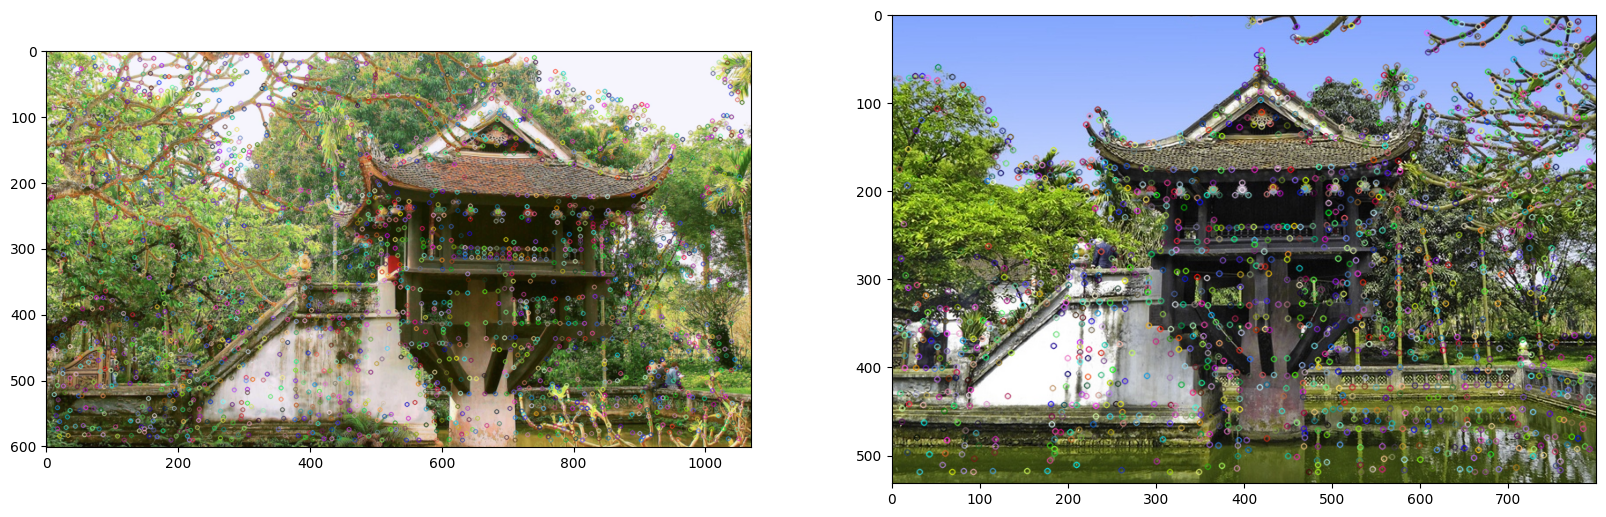

In [4]:
from matplotlib import pyplot as plt

fig, axes= plt.subplots(1,2,  figsize=(20, 20))
axes[0].imshow(cv2.cvtColor(keypoints0_image, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(keypoints1_image, cv2.COLOR_BGR2RGB))
plt.show()

# Match superpoint keypoints with KNN

number of inliers: 35


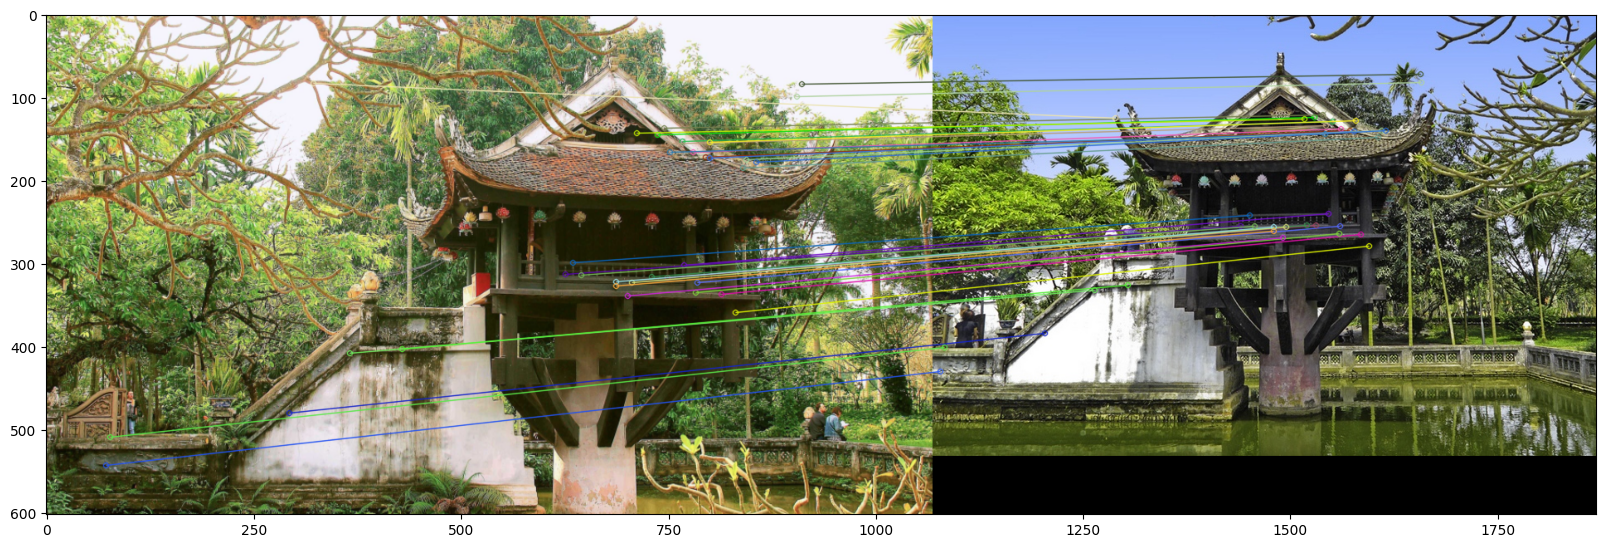

In [5]:
import numpy as np
from matplotlib import pyplot as plt

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors0, descriptors1)

M, mask = cv2.findHomography(
    np.float64([keypoints0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2),
    np.float64([keypoints1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2),
    method=cv2.USAC_MAGSAC,
    ransacReprojThreshold=5.0,
    maxIters=10000,
    confidence=0.999)
print(f"number of inliers: {mask.sum()}")
matches = np.array(matches)[np.all(mask > 0, axis=1)]
matches = sorted(matches, key=lambda match: match.distance)
matched_image = cv2.drawMatches(images[0],
                                keypoints0,
                                images[1],
                                keypoints1,
                                matches[:50],
                                None,
                                flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.show()